#Average IR SED for HRS

In [1]:
# Standard module imports
import numpy as np
import scipy.stats as stats
import pandas as pd
import sys
%matplotlib inline

# Useful directories
gh_dir = '/Users/ttshimiz/Github/'
sed_fit_dir = gh_dir + 'bat-agn-sed-fitting/'
casey_dir = sed_fit_dir + 'analysis/casey_bayes_results/'
data_dir = gh_dir + 'bat-data/'

In [2]:
# Setup the figures
execfile('../code/figure-setup.py')

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [3]:
# Upload the HRS fits
hrs_casey = pd.read_csv(casey_dir+'hrs_beta_fixed_2_wturn_gaussianPrior/final_fit_results_beta_fixed_2_wturn_gaussianPrior_hrs.csv', index_col=0)
hrs_casey_undetected = pd.read_csv(casey_dir+'hrs_beta_fixed_2_wturn_gaussianPrior/final_fit_results_beta_fixed_2_wturn_gaussianPrior_undetected_hrs.csv', index_col=0)
hrs_casey = pd.concat([hrs_casey, hrs_casey_undetected])
hrs_data = pd.read_table('../../hrs-data/hrs_photometry.txt', index_col=0)
# Upload the HRS info
hrs_info = pd.read_table(gh_dir+'hrs-data/hrs_photometry.txt', delimiter='\t', index_col=0, na_values=-99.99)

# HRS gas-rich galaxies
hrs_gas_rich = np.array([np.loadtxt(gh_dir+'hrs-data/hrs_gas_rich_numbers.txt')], dtype = int)[0]

hrs_casey['Mstar'] = hrs_info['logMstart']
hrs_low_mass = hrs_casey['Mstar'] <= 9.47

In [4]:
# Setup the SEDs
hrs_sed = pd.DataFrame({'W3': hrs_data['S12'], 'W4': hrs_data['S22'],
                        'PACS100': hrs_data['S100']*1000, 'PACS160': hrs_data['S160']*1000,
                        'PSW': hrs_data['S250'], 'PMW': hrs_data['S350'],
                        'PLW': hrs_data['S500']})

hrs_err = pd.DataFrame({'W3_err': hrs_data['err12'], 'W4_err': hrs_data['err22'],
                        'PACS100_err': hrs_data['err100']*1000, 'PACS160_err': hrs_data['err160']*1000,
                        'PSW_err': hrs_data['err_tot250'], 'PMW_err': hrs_data['err_tot350'],
                        'PLW_err': hrs_data['err_tot500']})
hrs_flag = hrs_data[['Flag12', 'Flag22', 'Flag100', 'Flag160', 'Flag250', 'Flag350', 'Flag500']]

hrs_err.loc[hrs_flag['Flag12'] == 0, 'W3_err'] = 5./3.*hrs_err.loc[hrs_flag['Flag12'] == 0, 'W3_err']
hrs_err.loc[hrs_flag['Flag22'] == 0, 'W4_err'] = 5./3.*hrs_err.loc[hrs_flag['Flag22'] == 0, 'W4_err']
hrs_err.loc[hrs_flag['Flag100'] == 0, 'PACS100_err'] = 5./3.*hrs_sed.loc[hrs_flag['Flag100'] == 0, 'PACS100']
hrs_err.loc[hrs_flag['Flag160'] == 0, 'PACS160_err'] = 5./3.*hrs_sed.loc[hrs_flag['Flag160'] == 0, 'PACS160']
hrs_err.loc[hrs_flag['Flag250'] == 0, 'PSW_err'] = 5./3.*hrs_sed.loc[hrs_flag['Flag250'] == 0, 'PSW']
hrs_err.loc[hrs_flag['Flag350'] == 0, 'PMW_err'] = 5./3.*hrs_sed.loc[hrs_flag['Flag350'] == 0, 'PMW']
hrs_err.loc[hrs_flag['Flag500'] == 0, 'PLW_err'] = 5./3.*hrs_sed.loc[hrs_flag['Flag500'] == 0, 'PLW']

hrs_sed.loc[hrs_flag['Flag12'] == 0, 'W3'] = 0
hrs_sed.loc[hrs_flag['Flag22'] == 0, 'W4'] = 0
hrs_sed.loc[hrs_flag['Flag100'] == 0, 'PACS100'] = 0
hrs_sed.loc[hrs_flag['Flag160'] == 0, 'PACS160'] = 0
hrs_sed.loc[hrs_flag['Flag250'] == 0, 'PSW'] = 0
hrs_sed.loc[hrs_flag['Flag350'] == 0, 'PMW'] = 0
hrs_sed.loc[hrs_flag['Flag500'] == 0, 'PLW'] = 0

In [5]:
# Import the ASURV package
sys.path.append(gh_dir+'asurv/')
import asurv

In [6]:
# Define the Lx bins and count the number of sources in each
bin_1 = hrs_casey['lir_total'] <= 8.5
bin_2 = (hrs_casey['lir_total'] > 8.5) & (hrs_casey['lir_total'] <= 9.0)
bin_3 = (hrs_casey['lir_total'] > 9.0) & (hrs_casey['lir_total'] <= 9.5)
bin_4 = (hrs_casey['lir_total'] > 9.5) & (hrs_casey['lir_total'] <= 10.0)
bin_5 = (hrs_casey['lir_total'] > 10.0)

print '# in Bin 1: ', sum(bin_1)
print '# in Bin 2: ', sum(bin_2)
print '# in Bin 3: ', sum(bin_3)
print '# in Bin 4: ', sum(bin_4)
print '# in Bin 5: ', sum(bin_5)

# in Bin 1:  24
# in Bin 2:  65
# in Bin 3:  92
# in Bin 4:  61
# in Bin 5:  30


In [7]:
bin_edges = np.array([8.5, 9.0, 9.5, 10.0])
n_bins = len(bin_edges) + 1
wavebands = ['LW3', 'LW4', 'LPACS100', 'LPACS160', 'LPSW', 'LPMW', 'LPLW']
sed = hrs_sed.join(hrs_err).loc[hrs_casey.index]
sed['Dist'] = hrs_info['Dist_Mpc']
#sed['LW1'] = 4*np.pi*(sed['Dist']*3.086e24)**2*sed['W1']*10**(-23)*10**(-30)
#sed['LW2'] = 4*np.pi*(sed['Dist']*3.086e24)**2*sed['W2']*10**(-23)*10**(-30)
sed['LW3'] = 4*np.pi*(sed['Dist']*3.086e24)**2*sed['W3']*10**(-23)*10**(-30)/1000.
sed['LW4'] = 4*np.pi*(sed['Dist']*3.086e24)**2*sed['W4']*10**(-23)*10**(-30)/1000.
sed['LPACS100'] = 4*np.pi*(sed['Dist']*3.086e24)**2*sed['PACS100']*10**(-23)*10**(-30)/1000.
sed['LPACS160'] = 4*np.pi*(sed['Dist']*3.086e24)**2*sed['PACS160']*10**(-23)*10**(-30)/1000.
sed['LPSW'] = 4*np.pi*(sed['Dist']*3.086e24)**2*sed['PSW']*10**(-23)*10**(-30)/1000.
sed['LPMW'] = 4*np.pi*(sed['Dist']*3.086e24)**2*sed['PMW']*10**(-23)*10**(-30)/1000.
sed['LPLW'] = 4*np.pi*(sed['Dist']*3.086e24)**2*sed['PLW']*10**(-23)*10**(-30)/1000.

#sed['LW1_err'] = 4*np.pi*(sed['Dist']*3.086e24)**2*sed['W1_err']*10**(-23)*10**(-30)
#sed['LW2_err'] = 4*np.pi*(sed['Dist']*3.086e24)**2*sed['W2_err']*10**(-23)*10**(-30)
sed['LW3_err'] = 4*np.pi*(sed['Dist']*3.086e24)**2*sed['W3_err']*10**(-23)*10**(-30)/1000.
sed['LW4_err'] = 4*np.pi*(sed['Dist']*3.086e24)**2*sed['W4_err']*10**(-23)*10**(-30)/1000.
sed['LPACS100_err'] = 4*np.pi*(sed['Dist']*3.086e24)**2*sed['PACS100_err']*10**(-23)*10**(-30)/1000.
sed['LPACS160_err'] = 4*np.pi*(sed['Dist']*3.086e24)**2*sed['PACS160_err']*10**(-23)*10**(-30)/1000.
sed['LPSW_err'] = 4*np.pi*(sed['Dist']*3.086e24)**2*sed['PSW_err']*10**(-23)*10**(-30)/1000.
sed['LPMW_err'] = 4*np.pi*(sed['Dist']*3.086e24)**2*sed['PMW_err']*10**(-23)*10**(-30)/1000.
sed['LPLW_err'] = 4*np.pi*(sed['Dist']*3.086e24)**2*sed['PLW_err']*10**(-23)*10**(-30)/1000.

binned_seds = pd.DataFrame(index=np.arange(n_bins),
                           columns=wavebands)
binned_seds_err_up = pd.DataFrame(index=np.arange(n_bins),
                                  columns=wavebands)
binned_seds_err_down = pd.DataFrame(index=np.arange(n_bins),
                                    columns=wavebands)

for i in range(n_bins):
    
    if i == 0:
        ind = hrs_casey['lir_total'] <= bin_edges[i]
    elif i == (n_bins - 1):
        ind = hrs_casey['lir_total'] > bin_edges[-1]
    else:
        ind = (hrs_casey['lir_total'] > bin_edges[i-1]) & (hrs_casey['lir_total'] <= bin_edges[i])
    
    for w in wavebands:
        
        f = sed.loc[ind, w].values
        ferr = sed.loc[ind, w+'_err'].values
        ul = f == 0
        f[ul] = ferr[ul]
        data = f
        cens= np.ones(len(data))
        cens[ul] = 0
        
        km = asurv.KaplanMeierDist(data=data, cens=cens)
        med = km.km_percentile(0.5)
        p16 = km.km_percentile(0.16)
        p84 = km.km_percentile(0.84)
        
        binned_seds.loc[i, w] = med
        binned_seds_err_down.loc[i, w] = med-p16
        binned_seds_err_up.loc[i, w] = p84-med

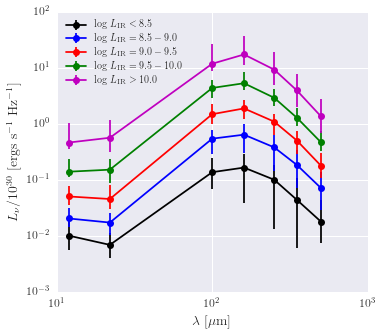

In [8]:
ll = np.array([12., 22., 100., 160., 250, 350., 500.])

fig = plt.figure(figsize=(0.8*textwidth, 1.2*3./4*0.8*textwidth))
ax1 = fig.add_subplot(111)
ax1.errorbar(ll, binned_seds.loc[0], yerr=np.vstack([binned_seds_err_down.loc[0], binned_seds_err_up.loc[0]]),
             fmt='o', color='k', ls='-', label=r'$\log\,L_{\rm IR} < 8.5$')
ax1.errorbar(ll, binned_seds.loc[1], yerr=np.vstack([binned_seds_err_down.loc[1], binned_seds_err_up.loc[1]]),
             fmt='o', color='b', ls='-', label=r'$\log\,L_{\rm IR} = 8.5-9.0$')
ax1.errorbar(ll, binned_seds.loc[2], yerr=np.vstack([binned_seds_err_down.loc[2], binned_seds_err_up.loc[2]]),
             fmt='o', color='r', ls='-', label=r'$\log\,L_{\rm IR} = 9.0-9.5$')
ax1.errorbar(ll, binned_seds.loc[3], yerr=np.vstack([binned_seds_err_down.loc[3], binned_seds_err_up.loc[3]]),
             fmt='o', color='g', ls='-', label=r'$\log\,L_{\rm IR} = 9.5-10.0$')
ax1.errorbar(ll, binned_seds.loc[4], yerr=np.vstack([binned_seds_err_down.loc[4], binned_seds_err_up.loc[4]]),
             fmt='o', color='m', ls='-', label=r'$\log\,L_{\rm IR} > 10.0$')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.legend(loc='upper left', fontsize=10)
ax1.set_ylabel(r'$L_{\nu}/10^{30}$ [ergs s$^{-1}$ Hz$^{-1}$]', fontsize=14)
ax1.set_xlabel('$\lambda$ [$\mu$m]', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=12)
sn.despine()
#fig.savefig(figsave_dir+'avg_sed_binned_lir_lnu_hrs.pdf', bbox_inches='tight')

In [21]:
# Construct the average of the whole HRS sample
hrs_whole_avg = pd.Series(index=wavebands)
hrs_whole_avg_err_up = pd.Series(index=wavebands)
hrs_whole_avg_err_dwn = pd.Series(index=wavebands)

for w in wavebands:
        
    f = sed[w].values
    ferr = sed[w+'_err'].values
    ul = f == 0
    f[ul] = ferr[ul]
    data = f
    cens= np.ones(len(data))
    cens[ul] = 0
        
    km = asurv.KaplanMeierDist(data=data, cens=cens)
    med = km.km_percentile(0.5)
    p16 = km.km_percentile(0.16)
    p84 = km.km_percentile(0.84)
        
    hrs_whole_avg[w] = med
    hrs_whole_avg_err_dwn[w] = med-p16
    hrs_whole_avg_err_up[w] = p84-med

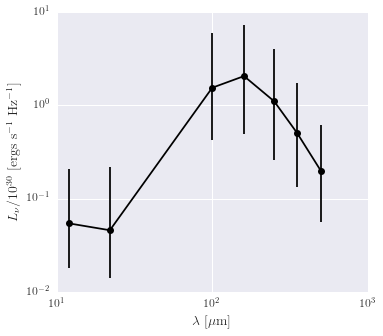

In [23]:
ll = np.array([12., 22., 100., 160., 250, 350., 500.])

fig = plt.figure(figsize=(0.8*textwidth, 1.2*3./4*0.8*textwidth))
ax1 = fig.add_subplot(111)
ax1.errorbar(ll, hrs_whole_avg, yerr=np.vstack([hrs_whole_avg_err_dwn,hrs_whole_avg_err_up]),
             fmt='o', color='k', ls='-')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylabel(r'$L_{\nu}/10^{30}$ [ergs s$^{-1}$ Hz$^{-1}$]', fontsize=14)
ax1.set_xlabel('$\lambda$ [$\mu$m]', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=12)
sn.despine()

In [24]:
hrs_whole_avg

LW3         0.054622
LW4         0.046096
LPACS100    1.547204
LPACS160    2.061236
LPSW        1.107824
LPMW        0.510250
LPLW        0.198203
dtype: float64

In [25]:
hrs_whole_avg_err_dwn

LW3         0.036230
LW4         0.031955
LPACS100    1.124512
LPACS160    1.560763
LPSW        0.846345
LPMW        0.376472
LPLW        0.141818
dtype: float64

In [26]:
hrs_whole_avg_err_up

LW3         0.154479
LW4         0.173004
LPACS100    4.451381
LPACS160    5.219838
LPSW        2.941576
LPMW        1.208210
LPLW        0.412873
dtype: float64

In [43]:
binned_seds_err_down

,LW3,LW4,LPACS100,LPACS160,LPSW,LPMW,LPLW
0,0.00451288,0.00291451,0.0684792,0.127947,0.0883733,0.0383158,0.0106523
1,0.00596903,0.00697563,0.252957,0.337974,0.241558,0.114199,0.0430417
2,0.0155666,0.0153769,0.479842,0.66479,0.460759,0.21432,0.0716941
3,0.0295391,0.0664208,1.46497,1.31777,0.810833,0.384628,0.14743
4,0.11461,0.256237,3.1342,6.2019,4.38488,1.94283,0.678348


In [44]:
binned_seds_err_up

,LW3,LW4,LPACS100,LPACS160,LPSW,LPMW,LPLW
0,0.0121228,0.00422784,0.110154,0.124901,0.0844412,0.0629377,0.025639
1,0.0111636,0.00838117,0.223388,0.35131,0.264492,0.157036,0.0690271
2,0.0276157,0.0356219,0.769544,0.815578,0.4005,0.236641,0.125089
3,0.0936224,0.0878445,1.79192,3.05906,1.36517,0.656215,0.276949
4,0.559676,0.605656,14.9459,19.2267,9.68702,3.97947,1.45456
